# FIA Predictive Modeling
### *Houston Sudekum*
### *January, 2020*

**Modules**
* pandas - data manipulation
* numpy - additional math functions
* patsy - create pandas dataframes or numpy arrarys from R style formulas for regression
* os - paths, folders etc.
* datetime
* FIA_functions - some functions that I made for matching and panel regression
* matplotlib and seaborn - plotting 

In [2]:
import pandas as pd
import numpy as np
import patsy
import os
import datetime
import FIA_functions as FIA
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

**Read in the provided data.**

In [3]:
path = "in_data"
path = os.path.join(path,"FIA_plots_16Dec19.csv")
all_plots =  pd.read_csv(path, low_memory=False).drop(columns = ['Unnamed: 0']).reset_index().rename(columns={"index": "X"})

**This is a shannon's diversitity index that I calculate when creating the dataset. Some values are NaN when there are no small diameter or large diameter trees on a plot. I am filling in those values here.**

In [4]:
all_plots.loc[:,['S_H','L_H']] = all_plots.loc[:,['S_H','L_H']].fillna(0)

**I am creating binary variables for each plot's distance to ports trading forest products, pulp mills, and biopower plants. Later on we can use these values as a proxy measure of 'within procurment radii' of the respective facility.**


In [5]:
miles = 0.621371
all_plots.loc[:,'prts_bi'] = [1 if i > 50 else 0 for i in all_plots.prts_d*miles]
all_plots.loc[:,'plp_bi'] = [1 if i > 50 else 0 for i in all_plots.plp_d*miles]
all_plots.loc[:,'biop_bi'] = [1 if i > 30 else 0 for i in all_plots.biop_d*miles]

**This list contains all of the columns that I transform with function below.**

In [6]:
transform_vars = ["livetree_carbon",
           "deadtree_carbon",
           "soil_carbon",
           "under_carbon",
           "L_dead_volcfgrs",
           "L_live_volcfgrs",
           "L_remvcfal"]

**This function gets the (minimum value greater than 0)/2 and adds that to every value in the column, so that we can use a natural log transformation.**

In [7]:
def yvar_trans(column):
    newcol = np.log(min([i for i in column if i > 0])/2 + column)
    return(newcol)

**Look at the columns pre-transformation**

In [8]:
all_plots.loc[:,transform_vars].describe()

,livetree_carbon,deadtree_carbon,soil_carbon,under_carbon,L_dead_volcfgrs,L_live_volcfgrs,L_remvcfal
count,84666.000000,84666.000000,84666.000000,84666.000000,83561.000000,83561.000000,83561.000000
mean,64.100520,1.387806,106.424063,5.700211,12.771084,135.587207,3.783707
std,53.453676,3.827826,334.452873,57.831673,30.431893,123.369449,24.089395
min,0.000000,0.000000,32.397611,1.359858,0.000000,0.000000,0.000000
25%,30.624111,0.000000,45.252572,2.980382,0.000000,56.948337,0.000000
50%,57.232726,0.030403,72.933629,3.860271,0.536021,116.539265,0.000000
75%,87.889832,1.222103,118.186201,6.058064,12.205906,186.666245,0.000000
max,5575.293092,249.228554,38638.651819,15624.390186,843.622716,10847.568399,5954.654308


**Apply the transformation to all columns.**

In [9]:
for i in transform_vars:
    all_plots.loc[:,i] = yvar_trans(all_plots.loc[:,i])

C:\Users\hjs5td\AppData\Local\ESRI\conda\envs\arcgispro_py3_new\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Convert all distances to natural logs**

In [10]:
distvars = [i for i in list(all_plots) if (i.endswith('_d'))|(i == 'pellet_min')]

for i in distvars:
    all_plots.loc[:,i] = np.log(all_plots.loc[:,i].astype('float32'))

**De-mean continous/discrete explanatory variables**


In [11]:
xvars = ["pdsi","poparea","pellet_min","pellet_count","plp_d","prts_d",
         "biop_d","adj_sicond","L_H","S_H","road_area","cos_aspect"]

all_plots.loc[:,xvars] = all_plots.loc[:,xvars].sub(all_plots.loc[:,xvars].mean())

**There are two seperate samples conatined in the csv (all removal plots and all remeasured plots). I created a key to distinguish the samples and we will only use one sample in this workbook. We filter out the remeasured plots and drop the removal plots.**


In [12]:
plots = all_plots.loc[all_plots.remv_key == 0,:].reset_index(drop = True)

**Change pellet count to only count values greater than 1**


In [13]:
plots.loc[:,'pellet_count'] = [int(i)-1 if i > 1 else 0 for i in plots.loc[:,'pellet_count']]


**Create a removal indicator for the remeasured plots to know which plots have any removals**


In [14]:
plots.loc[(plots.RTPA > 0)|(plots.L_remvcfal > 0),'remv_binary'] = 1

plots.loc[:,'remv_binary'] =  plots.remv_binary.fillna(0)

**This is formula and columns needed for PR-score matching with remeasured plots. We use wood product industry variables to gain a subsample of plots within radii of pellet mills and outside.**


In [15]:
col1 = ["plot_id","invyr","treatment","plp_pr_d","biop_pr_d",
        "prpop","prts_d",'road_area','statecd']

m1 = "treatment ~ plp_pr_d + prts_d + biop_pr_d + prpop + road_area + statecd"

**Get a dataframe for PR-score matching with remeasured plots.**


In [16]:
pr = plots.loc[pd.to_numeric(plots.invyr) > 2010,col1].reset_index(drop = True)

**Get a list of plot_id's that are treated, set all treatment to 1 so that we do not match treated to non treated, drop duplicates so we only have one plot_id**


In [17]:
treated = list(set([i for y,i in zip(list(pr.loc[:,'treatment']), list(pr.loc[:,'plot_id'])) if int(y) > 0]))

pr.loc[pr.plot_id.isin(treated),'treatment'] = 1

pr = pr.drop_duplicates(subset=['plot_id']).reset_index(drop = True)


**Change statecd to categorical so that patsy function below interprets it as such.**


In [18]:
pr.loc[:,'statecd'] = pd.Categorical(pr.statecd)

**Use a patsy function to make dataframes from the m1 formula and the pr dataframe**


In [19]:
y, X = patsy.dmatrices(m1, pr, return_type='dataframe')

**Import discrete models to use for PR-score matching.**


In [20]:
import statsmodels.discrete.discrete_model as ds

**Estimate and fit the models and get the propensity scores.**


In [21]:
prmod = ds.Probit(endog = y, exog = X)
matchmod = prmod.fit()
prscores = pd.Series(matchmod.predict()).rename('prscore')

Optimization terminated successfully.
         Current function value: 0.475481
         Iterations 7


**Merge the new prscores into the original dataframe.**


In [22]:
plts_pr = pr.merge(prscores, left_index = True, right_index = True).reset_index(drop = True)

**Format the sizes of legend and figure.**


In [23]:
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          'figure.figsize': (20,10)}
plt.rcParams.update(params)

**Plot the distribution of treated and non-treated plots after propensity score matching.**


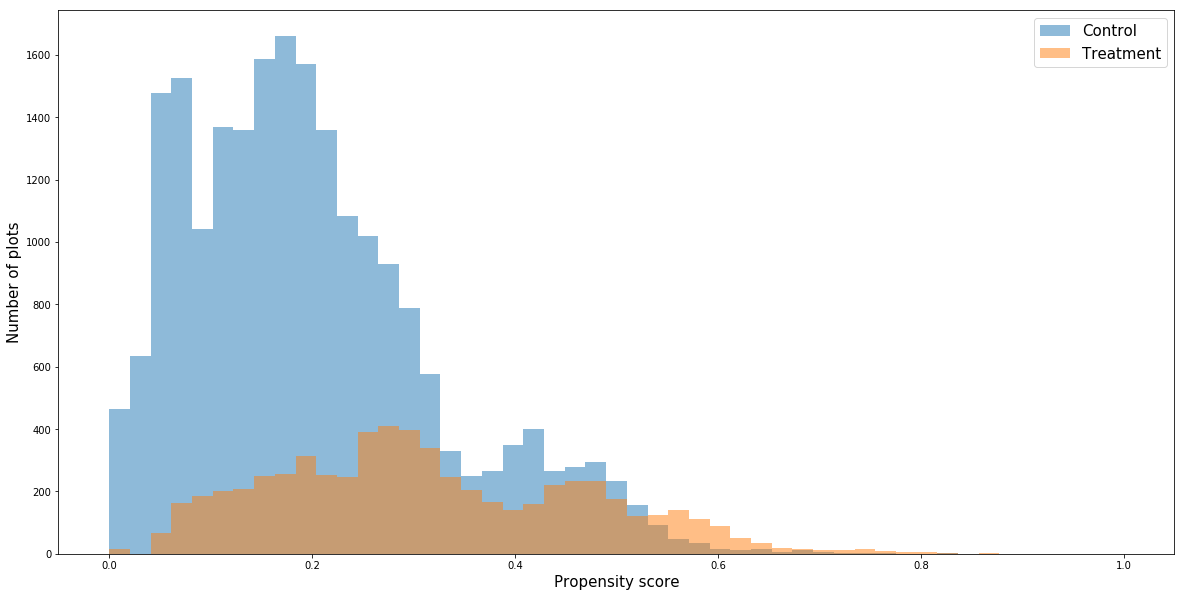

In [24]:
treat = plts_pr.loc[plts_pr['treatment'] > 0][['prscore']]
cont = plts_pr.loc[plts_pr['treatment'] == 0][['prscore']]
bins = np.linspace(0, 1, 50)
plt.hist(cont.prscore, bins, alpha=0.5, label='Control')
plt.hist(treat.prscore, bins, alpha=0.5, label='Treatment')
plt.legend(loc='upper right')
plt.ylabel('Number of plots', fontsize = 15)
plt.xlabel('Propensity score', fontsize = 15)


# display
plt.show()

**See the matchit function in FIA_functions.py. This function is designed to match each plot 1:1 based on a propensity score calculated from a logit/probit regression. Must input a pandas dataframe with a column name that indicates treatment and a column that contains prscores. This takes a long time because we have to evaluate each record and find the closest. Resampling can be set to true.**

In [25]:
matched_df = FIA.matchit(plts_pr,'treatment','prscore')

**Get the id's for all matched plots and get all observations of matched plots.**


In [26]:
keeperlist = list(matched_df.plot_id)
m_plots = plots.loc[plots.plot_id.isin(keeperlist),]

In [27]:
del plts_pr, keeperlist, matched_df, pr, y, X

**Use matched plots to estimate a panel regression model for volume in live trees with wood product industry and ecological descriptors.**

In [28]:
p_form = """adj_sicond + pdsi + pellet_min + pellet_min:pellet_50 + 
plp_d + poparea + prts_d + biop_d + L_H + S_H + cos_aspect + fire_wth + ins_dis + 
private + art_regen + private:art_regen"""

## Live-volume panel regression model

**This function runs a bunch of regressions depending upon how many numeric and non numeric effects are included. The function then runs Hausman tests and F-tests to determine the best model specification. Ultimately, the best model will be saved in the output. This function is reliant on statsmodels/linearmodels.**

In [29]:
live_vol = FIA.model_out(df = m_plots,
                   response_var = 'L_live_volcfgrs',
                   formula = p_form,
                   entity_index = 'plot_id',
                   numeric_effects = ['invyr'],
                   non_num_effects = ['ecosubs','statecd'])

C:\Users\hjs5td\AppData\Local\ESRI\conda\envs\arcgispro_py3_new\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hjs5td\AppData\Local\ESRI\conda\envs\arcgispro_py3_new\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\hjs5td\AppData\Local\ESRI\conda\envs\arcgispro_py3_new\lib\site-packages\IPython\core\interactiveshell.py:2881: PerformanceWarning:

In [30]:
live_vol.printit()

Fixed Effects : ['invyr', 'ecosubs', 'statecd']
No Random Effects

    
    
                                 Fixed Effects
    
    
        
                          PanelOLS Estimation Summary                           
Dep. Variable:        L_live_volcfgrs   R-squared:                        0.1748
Estimator:                   PanelOLS   R-squared (Between):              0.2390
No. Observations:               33150   R-squared (Within):               0.0339
Date:                Fri, Jan 17 2020   R-squared (Overall):              0.1748
Time:                        07:34:13   Log-likelihood                 -5.92e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      137.47
Entities:                       12479   P-value                           0.0000
Avg Obs:                       2.6565   Distribution:                F(51,33098)
Min Obs:                       1.0000          

**Binary choice models (removals, fire-weather, artificial regeneration) with intercept fixed effects.**

In [31]:
test = plots.loc[plots.remv_binary == 1,['invyr','plot_id','remv_binary']]

test2 = plots.sort_values(['plot_id','invyr']).loc[plots.plot_id.isin(list(test.plot_id)),['invyr','plot_id','remv_binary']]

first = test2.drop_duplicates(subset = 'plot_id',keep = 'first').fillna(0).remv_binary.sum()

second = sum(test2.remv_binary.fillna(0))

val = second - first

print('there are {} removal plots that have a previous measurement we could use for model estimation and {} total removal plots'.format(int(val),int(second)))

del test
del test2
del first
del second

there are 4358 removal plots that have a previous measurement we could use for model estimation and 9670 total removal plots


In [32]:
id_list = list(plots.loc[plots.remv_binary == 1,'plot_id'])    

In [33]:
newdf = plots.loc[plots.plot_id.isin(id_list),:]

In [34]:
allobs = len(newdf)

removalobs = int(sum(newdf.remv_binary.fillna(0)))

totalplots = len(newdf.plot_id.unique())

print("We have a total of {} plot observations, {} have a recorded removal and {} unique plot id's".format(allobs,removalobs,totalplots))

del allobs
del removalobs
del totalplots

We have a total of 23178 plot observations, 9670 have a recorded removal and 8636 unique plot id's


**Getting lagged values -- need to find a faster way to do this.**

In [35]:
ids = list(plots.plot_id.unique())

firstobs = []
dropit = []
index_dict = {}


for idx,i in enumerate(sorted(ids)):

    temp = plots.loc[plots.plot_id == i].sort_values(['invyr'])
    
    remv = sum(temp.remv_binary)
    
    if remv > 0:
        
        # just use this for a test below to make sure first obs is not removal
        
        minyear = min(list(pd.to_numeric(temp.invyr)))
        remvyear = min(list(pd.to_numeric(temp.loc[temp.remv_binary == 1,'invyr'])))
        
        # we plan to drop the whole plot if the first obs has a removal
        
        if minyear == remvyear:
            dropit.append(i)
            continue
        
    # we sort the df by inventory year and index so that the first value of
    # each iteration is the first obs in the plot which will eventually be dropped
    # I save this value to a list to create a binary later on

    for jdx,j in enumerate(temp.sort_values('invyr').index):
        if jdx == 0:
            # if it is the first one
            # save the index

            saveit = j
            
        else:

            # get the values from temp that we want

            t,v,r,rv,rb = list(temp.loc[saveit,['TPA','L_live_volcfgrs','RTPA','L_remvcfal','remv_binary']])

            # add them to a dictionary and save them with current index

            index_dict[j] = {'TPA':t,'L_live_volcfgrs':v,'RTPA':r,'L_remvcfal':rv,'remv_binary':rb}

            # save the current key

            saveit = j

In [36]:
lagged_vals = pd.DataFrame.from_dict(index_dict,orient='index').fillna(0)

In [37]:
# this inner join will drop all first observations of plots

plots_lag = plots.merge(lagged_vals,
                    how = 'inner',
                    left_index = True,
                    right_index = True,
                    indicator = True,
                    suffixes=('','_lag'))

**Import logistic model and random forest classifier**

In [64]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Removal Model

In [65]:
remv_form = """~ remv_binary_lag + L_live_volcfgrs_lag + pdsi + mjr_access + pellet_min + pellet_50
 + pellet_count + plp_d + poparea + biop_d + L_H + S_H + fire_wth + ins_dis + stat_fed + prts_d
 + C(ecosubs) + C(statecd) + art_regen"""

f1 = 'remv_binary ' + remv_form

In [70]:
plots_lag_train = plots_lag.loc[(plots_lag.invyr <= 2014),:]

In [71]:
y, X = patsy.dmatrices(f1, plots_lag_train, return_type='dataframe')

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [73]:
remv_out_mod = Logit(y_train,X_train)

In [74]:
remv_out = remv_out_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3156418106589134
            Iterations: 200
            Function evaluations: 202
            Gradient evaluations: 200


In [76]:
print(remv_out.summary())

                           Logit Regression Results                           
Dep. Variable:            remv_binary   No. Observations:                17344
Model:                          Logit   Df Residuals:                    17310
Method:                           MLE   Df Model:                           33
Date:                Fri, 17 Jan 2020   Pseudo R-squ.:                  0.1416
Time:                        07:45:49   Log-Likelihood:                -5474.5
converged:                       True   LL-Null:                       -6377.3
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.3296      0.187    -23.180      0.000      -4.696      -3.964
C(ecosubs)[T.M223]      0.2115      0.270      0.783      0.434      -0.318       0.741
C(ecosubs)[T.M23

In [359]:
predicted = remv_out.predict(X_test)

length = len(predicted)
predicted_bin = [1 if i > .5 else 0 for i in predicted]

matched = sum([1 for i,y in zip(predicted_bin,y_test.remv_binary) if i == y])
acc = matched/length

print('Accuracy of Logit predictor : {}'.format(round(acc,4)))

del predicted_bin
del predicted

Accuracy of Logit predictor : 0.8768


In [77]:
plots_lag_predict = plots_lag.loc[(plots_lag.invyr > 2014)&(plots_lag.remv_binary!=1),:]

y_predict,X_predict = patsy.dmatrices(f1, plots_lag_predict, return_type='dataframe')

In [78]:
# these are all the columns that are in X_predict and not in X

match = [i for i in list(X_predict) if i not in list(X)]

if len(match) > 0:
    for col in match:
        del X_predict[col]

# these are all the columns in X not in X_predict

miss = [i for i in list(X) if i not in list(X_predict)]

if len(miss) > 0:
    for col in match:
        X_predict[col] = 0
        
del match
del miss

In [79]:
predicted = remv_out.predict(X_predict)
predicted = predicted.rename('predict')

In [81]:
predicted_final = plots_lag_predict \
    .merge(predicted, left_index = True, right_index = True)

del predicted, X, y

In [82]:
import cartopy.crs as ccrs # these give us projectsions
import cartopy
import cartopy.geodesic as cgeo

In [83]:
def heat_scatter_map(df,lon,lat,color,title):
    
    plt.rcParams['figure.figsize'] = 20, 20
    
    lats = [df[lat].min()-4,df[lat].max()+4]
    lons = [df[lon].min()-4,df[lon].max()+4]
    latavg = np.mean(lats)
    lonavg = np.mean(lons)
    
    x = df[lon]
    y = df[lat]
    z = df[color]
    
    plt.axes(projection=ccrs.Mercator())
    ax = plt.axes(projection=ccrs.Mercator(lonavg))
    ax.set_extent(lons+lats)
    
    purp = sns.cubehelix_palette(as_cmap=True)
    
    plot = ax.scatter(x, y,c=z, cmap = purp,s = 5, transform=ccrs.Geodetic())
    
    states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.OCEAN)
            
    cbar = plt.colorbar(plot, shrink = .75)
    
    plt.title(title,fontsize = 20)
    return(ax)

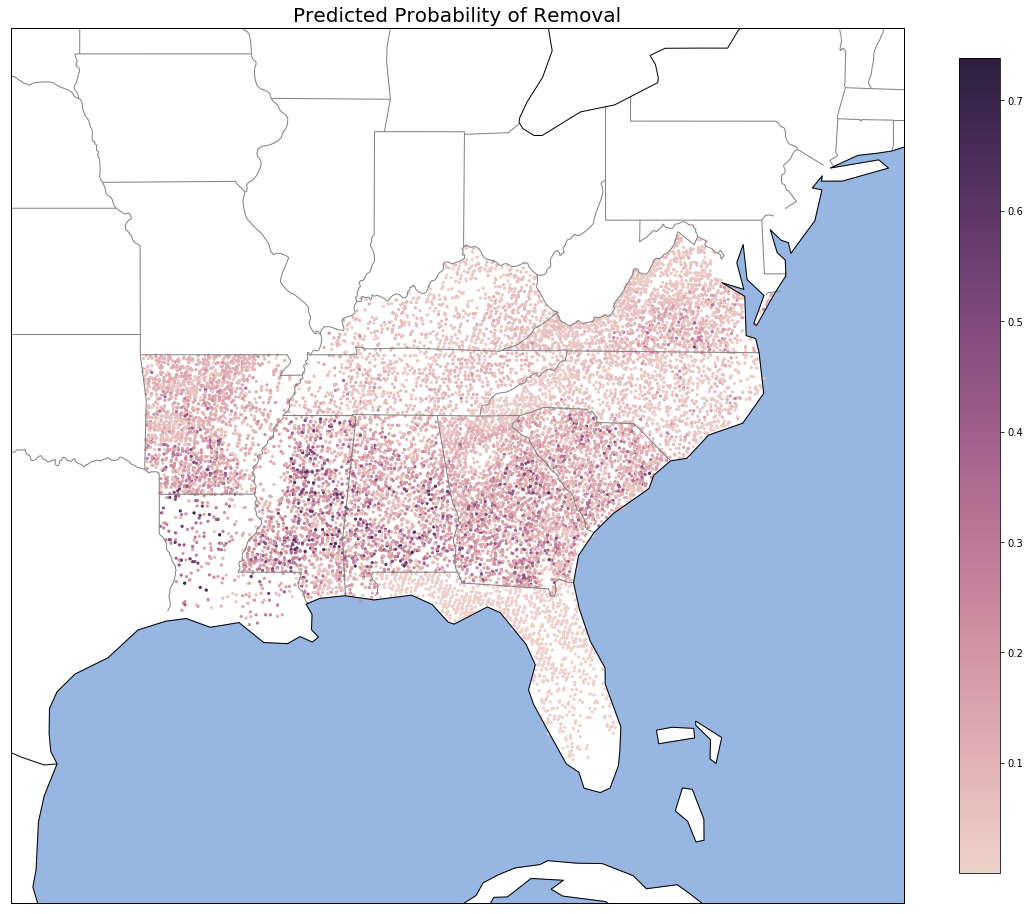

In [84]:
removal_map = heat_scatter_map(df = predicted_final,
                               lon = 'lon',
                               lat = 'lat',
                               color = 'predict',
                               title = 'Predicted Probability of Removal')

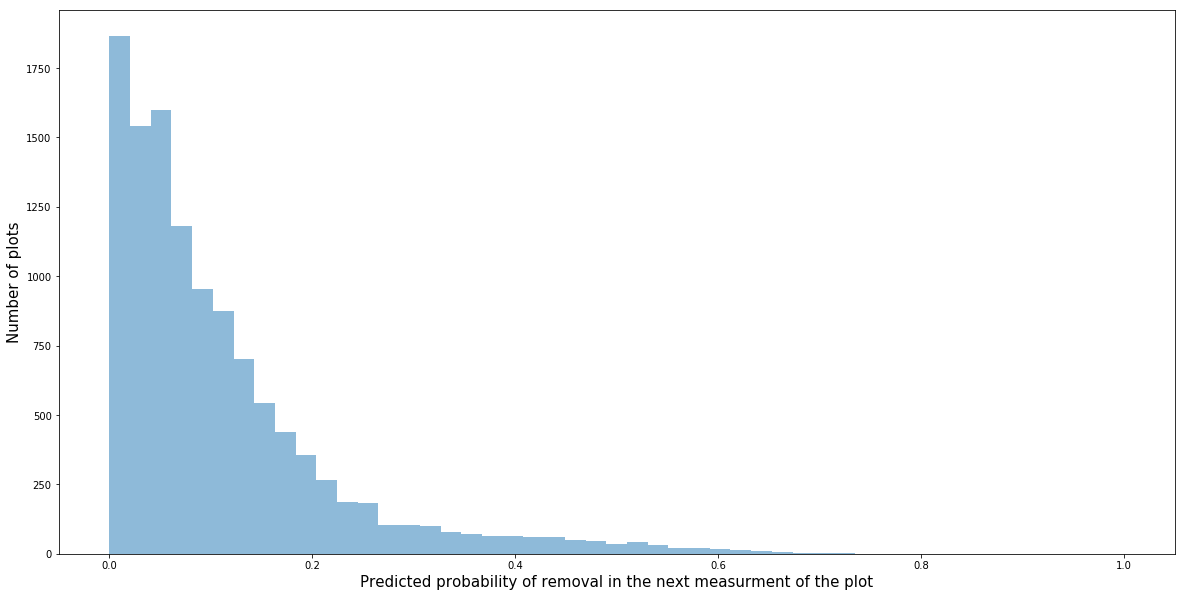

In [85]:
# reset figure size
plt.rcParams['figure.figsize'] = 20,10

# plot values in a histogram
bins = np.linspace(0, 1, 50)
plt.hist(predicted_final.predict, bins, alpha=0.5)
plt.ylabel('Number of plots', fontsize = 15)
plt.xlabel('Predicted probability of removal in the next measurment of the plot', fontsize = 15)
plt.show()


In [86]:
predicted_final['predict_bin'] = [1 if i > .5 else 0 for i in predicted_final.predict]


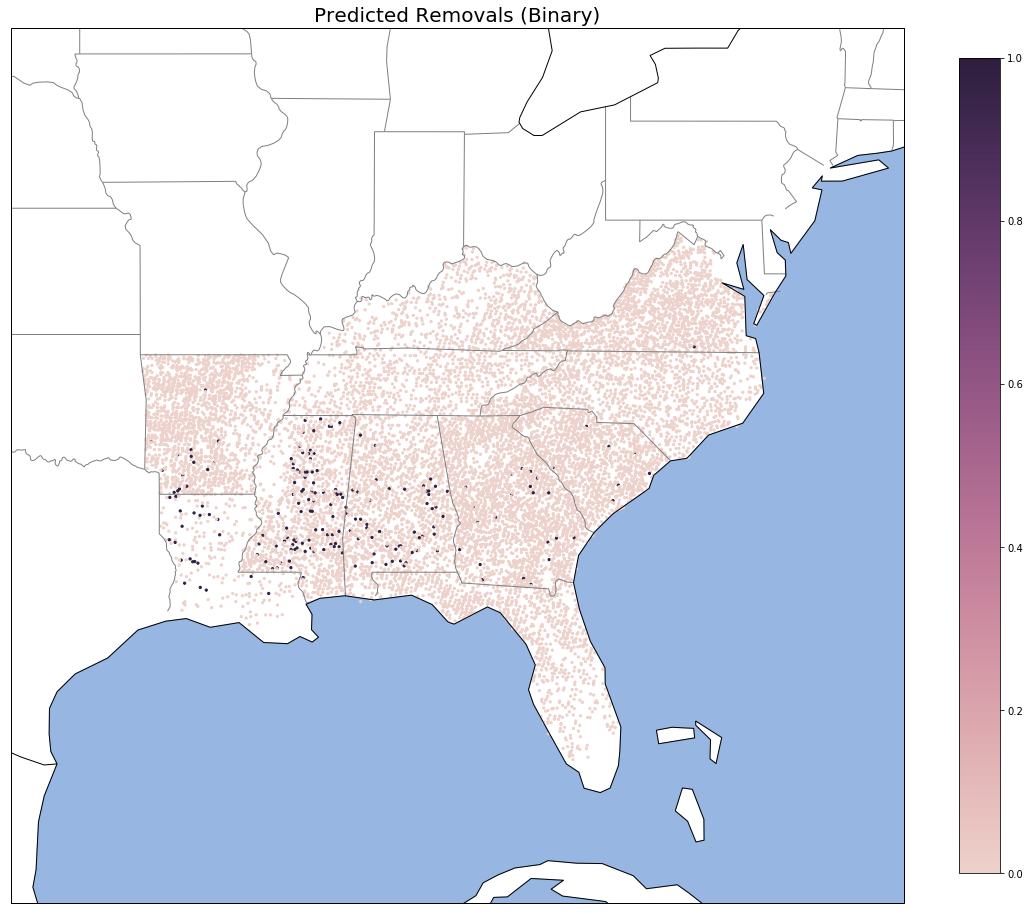

In [87]:
removal_map = heat_scatter_map(df = predicted_final,
                               lon = 'lon',
                               lat = 'lat',
                               color = 'predict_bin',
                               title = 'Predicted Removals (Binary)')

**Use a random forest classifier to estimate the same thing**

In [88]:
# same df as before

plots_lag_train = plots_lag.loc[(plots_lag.invyr <= 2014),:]

In [94]:
y, X = patsy.dmatrices(f1, plots_lag_train, return_type='matrix')

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [91]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
y_pred=clf.predict(X_test)

In [93]:
print("Accuracy of Random Forest Predictor :",metrics.accuracy_score(y_test, y_pred))

Accuracy of Random Forest Predictor : 0.8867366155501749


In [376]:
y_pred=clf.predict(X_predict)

In [377]:
predicted_final = predicted_final.loc[X_predict.index,:]


In [378]:
predicted_final['random_forest_predict'] = y_pred

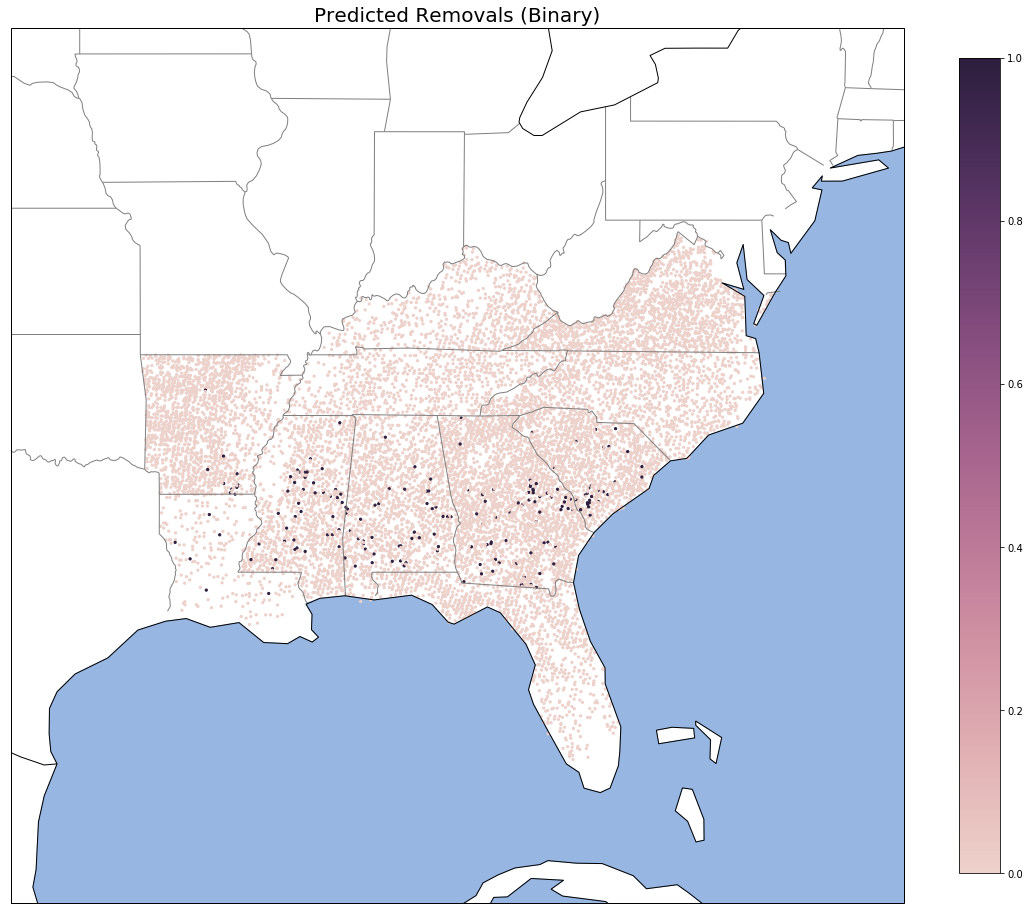

In [379]:
removal_map = heat_scatter_map(df = predicted_final,
                               lon = 'lon',
                               lat = 'lat',
                               color = 'random_forest_predict',
                               title = 'Predicted Removals (Binary)')

## Repeat methods for artificial regeneration and fire-weather disturbance (alter the explanatory variables)

**Artificial Regeneration Model**

In [85]:
regen_form = """~ mjr_access + pellet_min + pellet_50 + prts_d +
 + pellet_count + plp_d + poparea + biop_d + stat_fed 
 + C(ecosubs) + C(statecd)"""

f2 = 'art_regen ' + regen_form

In [88]:
y, X = patsy.dmatrices(f2, plots_lag, return_type='dataframe')

In [89]:
regen_mod = Logit(y,X)

In [90]:
regen_out = regen_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3810101705456398
            Iterations: 209
            Function evaluations: 209
            Gradient evaluations: 209


In [91]:
print(regen_out.summary())

                           Logit Regression Results                           
Dep. Variable:              art_regen   No. Observations:                36877
Model:                          Logit   Df Residuals:                    36849
Method:                           MLE   Df Model:                           27
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.1548
Time:                        20:52:45   Log-Likelihood:                -14051.
converged:                       True   LL-Null:                       -16625.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.8419      0.153    -25.145      0.000      -4.141      -3.542
C(ecosubs)[T.M223]    -0.0222      0.392     -0.056      0.955      -0.791       0.747
C(ecosubs)[T.M231]  

**Fire-Weather Model**

In [94]:
fire_form = """~ remv_binary + remv_binary_lag + L_live_volcfgrs_lag + pdsi + mjr_access + pellet_min + pellet_50
 + pellet_count + plp_d + poparea + biop_d + L_H + S_H + ins_dis + stat_fed + prts_d
 + C(ecosubs) + C(invyr) + C(statecd) + art_regen"""

f3 = 'fire_wth' + fire_form

In [95]:
y, X = patsy.dmatrices(f3, plots_lag, return_type='dataframe')

In [96]:
remv_out_mod = Logit(y,X)

In [97]:
remv_out = remv_out_mod.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.23453274976926142
            Iterations: 301
            Function evaluations: 303
            Gradient evaluations: 301


In [98]:
print(remv_out.summary())

                           Logit Regression Results                           
Dep. Variable:               fire_wth   No. Observations:                36877
Model:                          Logit   Df Residuals:                    36829
Method:                           MLE   Df Model:                           47
Date:                Thu, 19 Dec 2019   Pseudo R-squ.:                  0.1169
Time:                        20:53:19   Log-Likelihood:                -8648.9
converged:                       True   LL-Null:                       -9793.9
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.7956      0.264    -14.386      0.000      -4.313      -3.278
C(ecosubs)[T.M223]      0.8387      0.184      4.563      0.000       0.478       1.199
C(ecosubs)[T.M23